In [1]:
# Imports
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [2]:
# Dowloading training data
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Dowloading test data
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
# Passing data into DataLoader
# iterable, auto batching, sampling, shuffling and multiprocessing
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [4]:
# Creating model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512,10)
        )

    # Model flow
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
# Training Data
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Computing prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [6]:
# Testing data aka Validation
validation_loss = []

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    test_loss /= num_batches
    correct /= size
    validation_loss.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

Epoch 1
-------------------
loss: 2.301717 [   64/60000]
loss: 0.543605 [ 6464/60000]
loss: 0.388523 [12864/60000]
loss: 0.498199 [19264/60000]
loss: 0.442770 [25664/60000]
loss: 0.434011 [32064/60000]
loss: 0.382605 [38464/60000]
loss: 0.507319 [44864/60000]
loss: 0.516797 [51264/60000]
loss: 0.546801 [57664/60000]
Test Error: 
 Accuracy: 84.7%, Avg loss: 0.418880 

Epoch 2
-------------------
loss: 0.263817 [   64/60000]
loss: 0.352860 [ 6464/60000]
loss: 0.285120 [12864/60000]
loss: 0.379401 [19264/60000]
loss: 0.439918 [25664/60000]
loss: 0.399268 [32064/60000]
loss: 0.312328 [38464/60000]
loss: 0.480035 [44864/60000]
loss: 0.422663 [51264/60000]
loss: 0.480812 [57664/60000]
Test Error: 
 Accuracy: 85.4%, Avg loss: 0.400143 

Epoch 3
-------------------
loss: 0.208143 [   64/60000]
loss: 0.318300 [ 6464/60000]
loss: 0.221306 [12864/60000]
loss: 0.320693 [19264/60000]
loss: 0.373763 [25664/60000]
loss: 0.341217 [32064/60000]
loss: 0.281594 [38464/60000]
loss: 0.414270 [44864/60000]


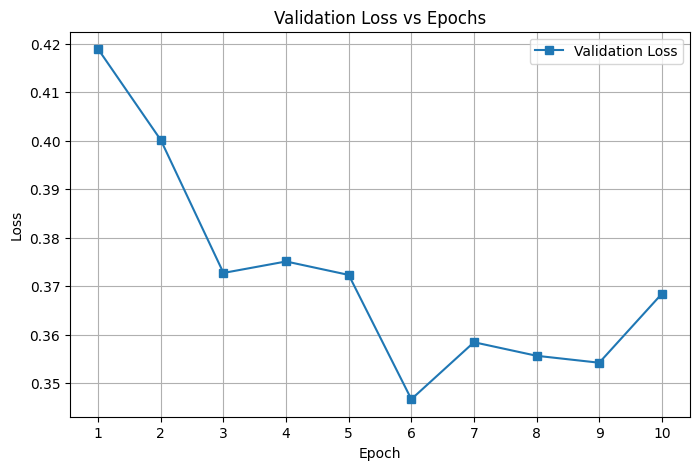

In [7]:
# Epoch loop
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Epoch cycle completed")

print("Generating Loss Graph...")
plot_epoch = list(range(1, epochs + 1))

plt.figure(figsize=(8,5))
plt.plot(plot_epoch, validation_loss, marker='s', label='Validation Loss')  # optional

plt.title("Validation Loss vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.xticks(plot_epoch)
plt.legend()
plt.grid(True)
plt.savefig("validation_plot.png")
print("Graph Generation Completed")

In [8]:
# Saving model
save_name = "weights_v1.pt"
torch.save(model.state_dict(), save_name)
print(f"Model weights saved as {save_name}")
print("Workflow completed")

# Loading model
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("weights_v1.pt", weights_only=True))

Model weights saved as weights_v1.pt
Workflow completed


<All keys matched successfully>

In [9]:
# Making prediction
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]


model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


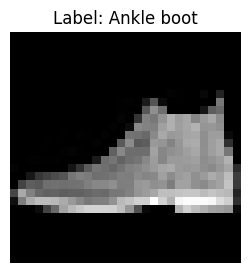

In [ ]:
plt.figure(figsize=(3,3))
plt.imshow(x.squeeze().cpu(), cmap="gray")
plt.title(f"Label: {classes[y]}")
plt.axis("off")
plt.show()
